In [1]:
# Install core libraries
!pip install -q beautifulsoup4 requests transformers sentence-transformers faiss-cpu langchain gradio
# Mount Drive for access to your knowledge base and saved models/indexes
from google.colab import drive
drive.mount('/content/drive')


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.8/23.8 MB 111.1 MB/s eta 0:00:00
Mounted at /content/drive


In [2]:
!pip install -U langchain-community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 76.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 45.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.1/489.1 kB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 5.4 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.4
    Uninstalling requests-2.32.4:
      Successfully uninstalled requests-2.32.4
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 1.2.1
    Uninstalling langchain-core-1.2.1:
      Successfully uninstalled langchain-core-1.2.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is inc

In [3]:
import os
from langchain_community.document_loaders import TextLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

KB_PATH = "/content/drive/MyDrive/new_wrexhamuniversity_scraped_data"

files = [os.path.join(dp, f) for dp, _, fn in os.walk(KB_PATH) for f in fn if f.endswith(".md")]
docs = [doc for f in files for doc in TextLoader(f, encoding="utf-8").load()]

splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
chunks = splitter.split_documents(docs)
texts = [chunk.page_content for chunk in chunks]
print(f"✅ {len(chunks)} chunks generated.")

✅ 330 chunks generated.


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/11 [00:00<?, ?it/s]

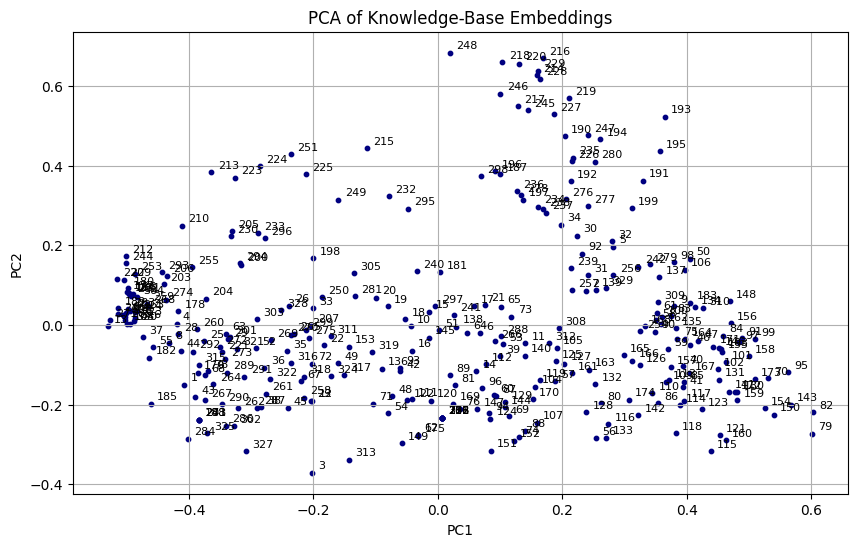

In [4]:
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# 1. Embed all chunks
embed_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
texts = [chunk.page_content for chunk in chunks]
embeddings = embed_model.encode(texts, show_progress_bar=True)

# 2. PCA to 2 dimensions
pca = PCA(n_components=2)
reduced = pca.fit_transform(embeddings)

# 3. Plot
plt.figure(figsize=(10, 6))
for i, (x, y) in enumerate(reduced):
    plt.scatter(x, y, s=10, c="navy")
    plt.text(x + 0.01, y + 0.01, str(i), fontsize=8)
plt.title("PCA of Knowledge-Base Embeddings")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()


In [5]:
import faiss
from langchain_community.vectorstores import FAISS as LangChainFAISS
from langchain_community.docstore import InMemoryDocstore
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_core.documents import Document

# 1. Raw FAISS index
dim = embeddings.shape[1]
faiss_index = faiss.IndexFlatL2(dim)
faiss_index.add(np.array(embeddings, dtype="float32"))

# 2. Prepare LangChain wrapper
docs = [Document(page_content=t) for t in texts]
docstore = InMemoryDocstore({str(i): docs[i] for i in range(len(docs))})
id_map = {i: str(i) for i in range(len(docs))}
embed_fn = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

vectorstore_faiss = LangChainFAISS(
    index=faiss_index,
    docstore=docstore,
    index_to_docstore_id=id_map,
    embedding_function=embed_fn
)

print("✅ FAISS vectorstore ready.")

/tmp/ipython-input-2202965470.py:16: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the `langchain-huggingface package and should be used instead. To use it run `pip install -U `langchain-huggingface` and import as `from `langchain_huggingface import HuggingFaceEmbeddings``.
  embed_fn = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")


✅ FAISS vectorstore ready.


In [23]:
query = "How old is Wrexham University?"
results = vectorstore_faiss.similarity_search(query, k=3)

print("Top-3 FAISS Results:")
for i, doc in enumerate(results):
    print(f"\n— Passage {i+1}:\n{doc.page_content[:300]}…")
query = "How old is Wrexham University?"
results = vectorstore_faiss.similarity_search(query, k=3)

# Concatenate context from results
context = "\n\n".join([doc.page_content for doc in results])


Top-3 FAISS Results:

— Passage 1:
Find out more about who we are and what we do.

Wrexham University is a Higher Education Corporation which was established under the 1988 Higher Education Reform Act in 1993 as the North East Wales Institute of Higher Education. It was granted its University title by the Privy Council on 3rd July 20…

— Passage 2:
Find out more about who we are and what we do.

We're hosting a series of online and on-campus events designed to answer your questions and give you an insight into studying and living at Wrexham University.

Wrexham University,Mold Road, Wrexham,LL11 2AW01978 290666

We welcome calls in Welsh or En…

— Passage 3:
Through strong links with industry, we ensure that each of our courses is designed to ensure you get the key skills needed for your chosen career.

Gain an insight into studying and student life at Wrexham University at one of our events.

Wrexham University,Mold Road, Wrexham,LL11 2AW01978 290666

…


WE ARE USING FIASS OPEN AI INSTEAD OF CHROMADB

In [24]:
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
import torch
from langchain_community.llms import HuggingFacePipeline

# 1. Load model from Drive
MODEL_PATH = "/content/drive/MyDrive/Colab Notebooks/model mistral"

tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
model = AutoModelForCausalLM.from_pretrained(
    MODEL_PATH,
    torch_dtype=torch.bfloat16,
    device_map="auto",
    offload_folder="tmp"
)

# 2. Build generation pipeline (NO sampling for academic reliability)
text_gen_pipeline = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    return_full_text=False,
    do_sample=False,            # IMPORTANT: prevents hallucination
    temperature=0.0,
    max_new_tokens=300,
    pad_token_id=tokenizer.eos_token_id
)

llm = HuggingFacePipeline(pipeline=text_gen_pipeline)

# 3. Prompt formatting (grounded, explicit)
def format_prompt(context, question):
    return f"""
You are the Wrexham University Assistant.

Answer ONLY using the information provided in the context below.
If the answer is not stated in the context, reply exactly with:
"The available university documents do not mention this explicitly."

Context:
{context}

Question:
{question}

Answer:
"""

# 4. Retrieval-augmented answer function
def answer_fn(question, k=5):
    docs = vectorstore_faiss.similarity_search(question, k=k)

    if not docs:
        return "The available university documents do not mention this explicitly."

    context = "\n\n".join(doc.page_content for doc in docs)
    prompt = format_prompt(context, question)

    try:
        response = llm.invoke(prompt)
        return response.strip()
    except Exception as e:
        return f"An error occurred while generating the response: {e}"

# 5. Gradio chat wrapper
def chat_fn(user_message, history):
    if history is None:
        history = []

    bot_response = answer_fn(user_message)
    history.append((user_message, bot_response))

    return history, history

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

The module name model mistral (originally model mistral) is not a valid Python identifier. Please rename the original module to avoid import issues.
Device set to use cuda:0


In [8]:
test_queries = [
    "What are the general entry requirements for undergraduate courses?",
    "What are the entry requirements for postgraduate study?",
    "Do international students need an English language qualification?",
    "What IELTS score is required for admission?",
    "Can mature students apply without traditional qualifications?",
    "Is there an application deadline for undergraduate courses?",
    "How do I apply for a course at Wrexham University?",
    "Are foundation courses available?",
    "Can I apply through UCAS?",
    "Are part-time study options available?",

    "How are undergraduate courses structured?",
    "What types of assessments are used on degree programmes?",
    "Are there exams or coursework assessments?",
    "How many credits are required per academic year?",
    "What is the grading system used by the university?",
    "How long does a full-time undergraduate course take?",
    "Are work placements included in courses?",
    "How is student attendance monitored?",
    "Can students change modules after enrolment?",
    "How are final degree classifications calculated?",

    "What are the tuition fees for undergraduate courses?",
    "What are the tuition fees for international students?",
    "Are there scholarships available?",
    "How do students apply for student finance?",
    "Are payment plans available for tuition fees?",
    "What additional costs should students expect?",
    "Are there bursaries for low-income students?",
    "What happens if tuition fees are paid late?",
    "Are refunds available if a student withdraws?",
    "Do postgraduate courses have different fee structures?",

    "What happens if a student fails a module?",
    "Are resits allowed for failed assessments?",
    "What are the rules on academic misconduct?",
    "What is plagiarism and how is it handled?",
    "Can students appeal an assessment decision?",
    "What is the policy on mitigating circumstances?",
    "How many attempts are allowed per module?",
    "What are the progression requirements between years?",
    "What happens if a student interrupts their studies?",
    "Where can students find academic regulations?",

    "What student support services are available?",
    "Is there academic support for struggling students?",
    "What wellbeing services does the university offer?",
    "Is there support for international students?",
    "Does the university provide disability support?",
    "How can students access mental health support?",
    "Is there career guidance available?",
    "What library services are provided?",
    "Is there IT support for students?",
    "How do students contact student services?"
]


In [9]:
from sentence_transformers import SentenceTransformer, util
import pandas as pd
import time

similarity_model = SentenceTransformer("all-MiniLM-L6-v2")


In [10]:
def auto_accuracy_label(answer, context):
    if not context.strip():
        return "Limited"

    answer_emb = similarity_model.encode(answer, convert_to_tensor=True)
    context_emb = similarity_model.encode(context, convert_to_tensor=True)

    score = util.cos_sim(answer_emb, context_emb).item()

    if score >= 0.65:
        return "Fully accurate"
    elif score >= 0.45:
        return "Partially accurate"
    else:
        return "Limited"


In [11]:
import time
import pandas as pd

evaluation_results = []

for query in test_queries:
    docs = vectorstore_faiss.similarity_search(query, k=5)
    context = "\n\n".join(d.page_content for d in docs) if docs else ""

    start = time.time()
    answer = answer_fn(query)
    end = time.time()

    evaluation_results.append({
        "query": query,
        "answer": answer,
        "response_time_seconds": round(end - start, 2),
        "accuracy_label": auto_accuracy_label(answer, context),
        "direct_answer": ""          # Yes / No (manual)
    })

Retrieved docs: ["Find out more about who we are and what we do.\n\nFor the majority of undergraduate courses, you'll ne", 'see our full time undergraduate student fee FAQs.', 'Postgraduate\n\nMA/MSc\n\n£12,500\n\nMBA\n\n£13,000\n\nMSc with Advanced Practice\n\nStandard programme fee + £3', 'Find out more about who we are and what we do.\n\nCourse Fees\n\nCourse\n\n2025-26\n\nFee\n\nInternational Fou', 'There is no definitive way of writing a personal statement which will guarantee acceptance onto your']
Context for prompt:
Find out more about who we are and what we do.

For the majority of undergraduate courses, you'll need to apply through UCAS. Once you’ve decided on which courses you wish to apply for, then you’ll need to register at UCAS.com to start your application.

see our full time undergraduate student fee FAQs.

Postgraduate

MA/MSc

£12,500

MBA

£13,000

MSc with Advanced Practice

Standard programme fee + £3,500

MBA with Advanced Practice

Standard programme fee + £3,50

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Raw LLM output:
Yes, part-time study options are available.
Retrieved docs: ['see our full time undergraduate student fee FAQs.', "Find out more about who we are and what we do.\n\nWhether you're learning something new or developing ", 'Find out more about who we are and what we do.\n\nCourse Fees\n\nCourse\n\n2025-26\n\nFee\n\nInternational Fou', "Find out more about who we are and what we do.\n\nFor the majority of undergraduate courses, you'll ne", 'The international student fees mentioned above, cover the tuition fees only and do not cover accommo']
Context for prompt:
see our full time undergraduate student fee FAQs.

Find out more about who we are and what we do.

Whether you're learning something new or developing your existing skills, our range of online short courses will help you take that next step.

50+ online short courses available

We have courses you can study at a time that suits you or at set class times, so if you're fitting in study around your job or family commitm

In [12]:
results_df = pd.DataFrame(evaluation_results)

In [13]:
specific_phrase = "I’m sorry, but I don’t have that information available right now."

results_df.loc[
    results_df["answer"].str.contains(specific_phrase, na=False),
    "direct_answer"
] = "NO"

results_df.loc[
    results_df["direct_answer"] != "NO",
    "direct_answer"
] = "YES"


In [14]:
results_df.to_csv("automated_chatbot_evaluation_results.csv", index=False)
print("updated successfully.")

updated successfully.


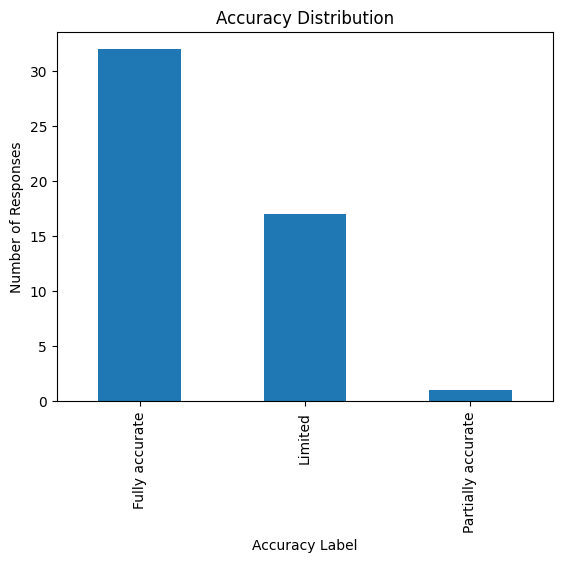

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the evaluation results (Excel file)
file_path = "/content/UPDATED_chatbot_evaluation_results (1).csv.xlsx"
df = pd.read_excel(file_path)

#Chart 1: Accuracy Distribution
accuracy_counts = df["accuracy_label"].value_counts()

plt.figure()
accuracy_counts.plot(kind="bar")
plt.title("Accuracy Distribution")
plt.xlabel("Accuracy Label")
plt.ylabel("Number of Responses")
plt.show()



### Figure Above shows the distribution of response accuracy across the fifty evaluation queries, indicating that the majority of chatbot responses were fully aligned with official university documentation

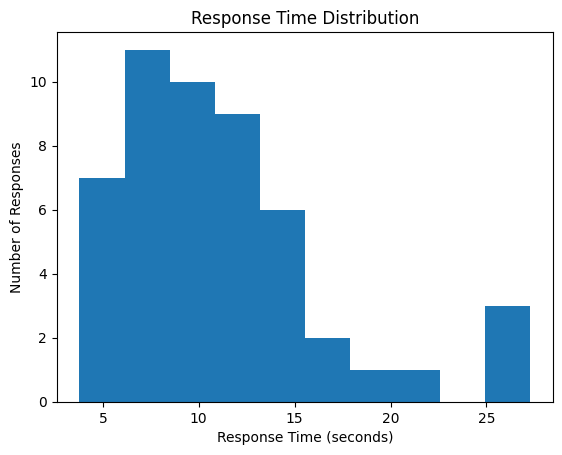

In [16]:
#Chart 2: Response Time Distribution
plt.figure()
plt.hist(df["response_time_seconds"], bins=10)
plt.title("Response Time Distribution")
plt.xlabel("Response Time (seconds)")
plt.ylabel("Number of Responses")
plt.show()

## Figure above illustrates the response time distribution, demonstrating that the system consistently generated responses within a short and stable time range suitable for real-time interaction

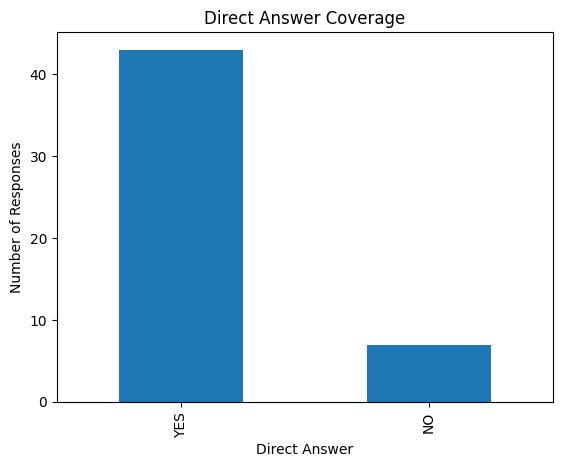

In [17]:
#Chart 3: Direct Answer Coverage
direct_answer_counts = df["direct_answer"].value_counts()

plt.figure()
direct_answer_counts.plot(kind="bar")
plt.title("Direct Answer Coverage")
plt.xlabel("Direct Answer")
plt.ylabel("Number of Responses")
plt.show()

## Figure above presents direct answer coverage, showing that most queries were answered without requiring redirection to external pages.

In [18]:
import sys

# Get embedding size
embedding_size = embeddings.shape[1]

# Get vector count
vector_count = embeddings.shape[0]

# Estimate index size (each float32 is 4 bytes)
# Note: This is an approximation for IndexFlatL2, the actual size may vary slightly based on FAISS internal structures.
index_size_bytes = vector_count * embedding_size * 4

def convert_bytes(size):
    for unit in ['bytes', 'KB', 'MB', 'GB', 'TB']:
        if size < 1024.0:
            return f"{size:.2f} {unit}"
        size /= 1024.0

print("FAISS Database Statistics:")
print("------------------------")
print(f"Embedding Size (dimensions): {embedding_size}")
print(f"Vector Count: {vector_count}")
print(f"Approximate Index Size: {convert_bytes(index_size_bytes)}")

FAISS Database Statistics:
------------------------
Embedding Size (dimensions): 384
Vector Count: 330
Approximate Index Size: 495.00 KB


In [26]:
import gradio as gr

def gradio_chat(user_message, history):
    if history is None:
        history = []

    answer = answer_fn(user_message)
    history.append((user_message, answer))

    return history, history


with gr.Blocks(title="Wrexham University Assistant") as demo:

    gr.Markdown(
        """
        ## Wrexham University Virtual Assistant

        This system answers questions on admissions, courses, fees,
        academic regulations, and student support.

        Responses are generated using retrieval from official
        university documents.
        """
    )

    chatbot = gr.Chatbot(
        label="Conversation",
        height=420,
        show_copy_button=True
    )

    user_input = gr.Textbox(
        label="Ask a question",
        placeholder="Ask about admissions, assessments, or support services",
        lines=2
    )

    with gr.Row():
        submit_btn = gr.Button("Send")
        clear_btn = gr.Button("Clear chat")

    # ✅ show_progress added
    submit_btn.click(
        fn=gradio_chat,
        inputs=[user_input, chatbot],
        outputs=[chatbot, chatbot],
        show_progress=True
    )

    user_input.submit(
        fn=gradio_chat,
        inputs=[user_input, chatbot],
        outputs=[chatbot, chatbot],
        show_progress=True
    )

    clear_btn.click(
        fn=lambda: [],
        outputs=chatbot
    )

demo.launch()


/tmp/ipython-input-721749782.py:27: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  chatbot = gr.Chatbot(
/tmp/ipython-input-721749782.py:27: DeprecationWarning: The 'show_copy_button' parameter will be removed in Gradio 6.0. You will need to use 'buttons=["copy"]' instead.
  chatbot = gr.Chatbot(
/tmp/ipython-input-721749782.py:27: DeprecationWarning: The default value of 'allow_tags' in gr.Chatbot will be changed from False to True in Gradio 6.0. You will need to explicitly set allow_tags=False if you want to disable tags in your chatbot.
  chatbot = gr.Chatbot(


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://ddecbc818ca4dfd982.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
